In [1]:
import time
import os
import cv2 as cv
import numpy as np
import math
import pandas as pd
from sklearn.cluster import KMeans
from PIL import Image, ImageOps
from matplotlib import pyplot as plt
from matplotlib import collections  as mc
import pylab as pl

In [2]:
SAVE = True
PLOT = True
SELECTION = 'Basic Skewed'
VERT_THRESHOLD = 0.80

In [3]:
# set image input paths
img_dir = os.path.join(os.getcwd(), "images")
file_paths = {
    'Basic' : "basic_city.png",
    'Basic Skewed' : "basic_skewed_city.png",
    'Realistic' : "realistic_city.jpg"
}
file_name = file_paths[SELECTION]

# set load path
basic_img_path = os.path.join(img_dir, file_name)

# set save paths
save_dir = os.path.join(img_dir, SELECTION)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
gray_img_path = os.path.join(save_dir, "gray_" + file_name)
canny_img_path = os.path.join(save_dir, "canny_" + file_name)
hough_img_path = os.path.join(save_dir, "hough_" + file_name)
clustered_img_path = os.path.join(save_dir, "culstered_" + file_name)

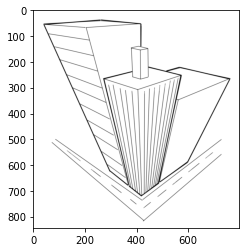

In [4]:
# read image in
src = Image.open(basic_img_path)
src = ImageOps.grayscale(src)

if PLOT:
    plt.imshow(src, cmap='gray',)
if SAVE:
    src.save(gray_img_path)

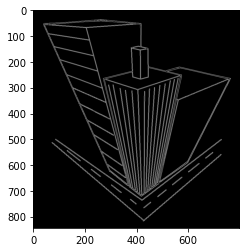

In [5]:
# perform canny edge detector
dst = cv.Canny(np.array(src), 50, 200, None, 3)

if PLOT:
    plt.imshow(dst, cmap='gray')
if SAVE:
    Image.fromarray(dst).save(canny_img_path)

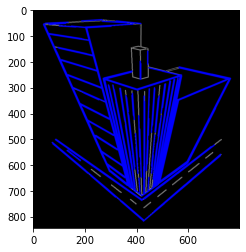

In [6]:
# Copy edges to the images that will display the results in BGR
cdst = cv.cvtColor(dst, cv.COLOR_GRAY2BGR)
        
linesP = cv.HoughLinesP(dst, 1, np.pi / 180, 50, None, 50, 4)
    
if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv.line(cdst, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv.LINE_AA)
        
if PLOT:        
    plt.imshow(cdst, cmap='gray')
if SAVE:
    Image.fromarray(cdst).save(hough_img_path)

## Auto cluster 'vertical slopes' first

In [7]:
# n, one, four = linesP.shape
# coords = np.reshape(linesP, (n, 4))

# # get p1coords and p2 coords
# p1coords = coords[:,0:2]  # x1, y1
# p2coords = coords[:,2:4]  # x2, y2

# # thetas are slope of line between point 1 and point 2
# slopes = (p2coords[:,1] - p1coords[:,1]) / (p2coords[:,0] - p1coords[:,0])

# # eliminate points with infinite slope
# good_indices = np.isfinite(slopes)
# p1coords = p1coords[good_indices]
# p2coords = p2coords[good_indices]
# lengths = np.linalg.norm(p2coords - p1coords, axis=1)
# slopes = slopes[good_indices]
# angles = np.arctan(slopes)
# unit_x = np.cos(angles)
# unit_y = np.sin(angles)

# print(min(angles))
# print(max(angles))

# #cluster_0_indices = np.argwhere(90 -  < angles < 110)



# # offset p2coords, p1coords are now at (0,0)
# p1coords_off = np.zeros(p1coords.shape)
# p2coords_off = p2coords - p1coords

# # normalize p2coords to get vectors of points on the unit circle
# unit_coords = p2coords_off / np.linalg.norm(p2coords_off, axis=1, keepdims=True)

# # cluster based on x, y coordinates of points on unit circle
# kmeans = KMeans(n_clusters=3, n_init=100, random_state=42)
# kmeans_labels = kmeans.fit_predict(unit_coords)

# cluster_0_indices = np.argwhere(kmeans_labels == 0)
# cluster_1_indices = np.argwhere(kmeans_labels == 1)
# cluster_2_indices = np.argwhere(kmeans_labels == 2)

# cluster_0_lines = coords[cluster_0_indices].reshape(-1,4)
# cluster_1_lines = coords[cluster_1_indices].reshape(-1,4)
# cluster_2_lines = coords[cluster_2_indices].reshape(-1,4)

# # display
# cdst = cv.cvtColor(dst, cv.COLOR_GRAY2BGR)
# if cluster_0_lines is not None:
#     for l in cluster_0_lines:
#         cv.line(cdst, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv.LINE_AA)
        
# if cluster_1_lines is not None:
#     for l in cluster_1_lines:
#         cv.line(cdst, (l[0], l[1]), (l[2], l[3]), (0,255,0), 3, cv.LINE_AA)
        
# if cluster_2_lines is not None:
#     for l in cluster_2_lines:
#         cv.line(cdst, (l[0], l[1]), (l[2], l[3]), (255,0,0), 3, cv.LINE_AA)
        
# print(len(cluster_0_lines))
# print(len(cluster_1_lines))
# print(len(cluster_2_lines))

# if PLOT:
#     plt.imshow(cdst, cmap='gray')
# if SAVE:
#     Image.fromarray(cdst).save(clustered_img_path)

## Normalizing first before doing clustering

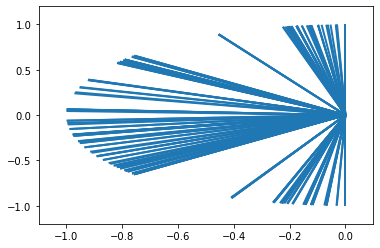

In [8]:
n, one, four = linesP.shape
coords = np.reshape(linesP, (n, 4))

# get p1coords and p2 coords
p1coords = coords[:,0:2]  # x1, y1
p2coords = coords[:,2:4]  # x2, y2

# offset p2coords, p1coords are now at (0,0)
origin_coords = np.zeros(p1coords.shape)
p2coords_off = p1coords - p2coords

# normalize p2coords to get vectors of points on the unit circle
unit_coords = p2coords_off / np.linalg.norm(p2coords_off, axis=1, keepdims=True)

# plot the unit vectors
if PLOT:
    lines = zip(unit_coords, origin_coords)
    lc = mc.LineCollection(lines,  linewidths=2)
    fig, ax = pl.subplots()
    ax.add_collection(lc)
    ax.autoscale()
    ax.margins(0.1)
    fig.show

## Now automatically remove the vertical cluster 
### This introduces the assumption that there are strong vertical lines in the scene

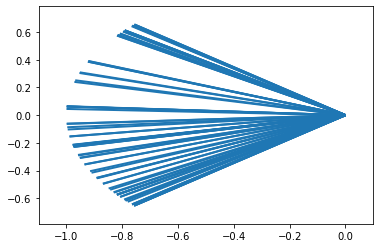

In [9]:
# get vertical lines and seperate their cluster
cluster_0_indices_1 = np.argwhere(unit_coords[:,1] > VERT_THRESHOLD)
cluster_0_indices_2 = np.argwhere(unit_coords[:,1] < -VERT_THRESHOLD)
cluster_0_indices = np.concatenate((cluster_0_indices_1, cluster_0_indices_2)).reshape(-1)

cluster_0 = coords[cluster_0_indices]

unit_coords_no_verts = np.delete(unit_coords, cluster_0_indices, axis=0)
origin_coords_no_verts = np.delete(origin_coords, cluster_0_indices, axis=0)
coords_no_verts = np.delete(coords, cluster_0_indices, axis=0)

shifted_cluster_1 = np.abs(unit_coords_no_verts[:,1] - (VERT_THRESHOLD / 2))
cluster_1_indices = np.argwhere(shifted_cluster_1 < VERT_THRESHOLD / 2).reshape(-1)

shifted_cluster_1 = np.abs(-unit_coords_no_verts[:,1] - (VERT_THRESHOLD / 2))
cluster_2_indices = np.argwhere(shifted_cluster_1 < VERT_THRESHOLD / 2).reshape(-1)


# plot the unit vectors
if PLOT:
    lines = zip(unit_coords_no_verts, origin_coords_no_verts)
    lc = mc.LineCollection(lines, linewidths=2)
    fig, ax = pl.subplots()
    pl.xlim([-1.0,1.0])
    ax.add_collection(lc)
    ax.autoscale()
    ax.margins(0.1)
    fig.show

# cluster_1_indices = np.argwhere(kmeans_labels == 1)
# cluster_2_indices = np.argwhere(kmeans_labels == 2)

## Now manually cluster the remaining two angles based on whether they are > 0 or < 0

90
32
51


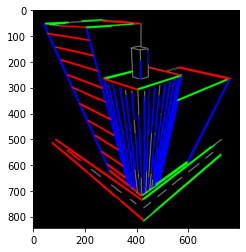

In [10]:
# cluster based on x, y coordinates of points on unit circle
# kmeans = KMeans(n_clusters=2, n_init=1000, random_state=42)
# kmeans_labels = kmeans.fit_predict(unit_coords_no_verts)

# cluster_1_indices = np.argwhere(kmeans_labels == 1)
# cluster_2_indices = np.argwhere(kmeans_labels == 2)

cluster_0_lines = coords[cluster_0_indices].reshape(-1,4)
cluster_1_lines = coords_no_verts[cluster_1_indices].reshape(-1,4)
cluster_2_lines = coords_no_verts[cluster_2_indices].reshape(-1,4)

# display
cdst = cv.cvtColor(dst, cv.COLOR_GRAY2BGR)
if cluster_0_lines is not None:
    for l in cluster_0_lines:
        cv.line(cdst, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv.LINE_AA)
        
if cluster_1_lines is not None:
    for l in cluster_1_lines:
        cv.line(cdst, (l[0], l[1]), (l[2], l[3]), (0,255,0), 3, cv.LINE_AA)
        
if cluster_2_lines is not None:
    for l in cluster_2_lines:
        cv.line(cdst, (l[0], l[1]), (l[2], l[3]), (255,0,0), 3, cv.LINE_AA)
        
print(len(cluster_0_lines))
print(len(cluster_1_lines))
print(len(cluster_2_lines))

if PLOT:
    plt.imshow(cdst, cmap='gray')
if SAVE:
    Image.fromarray(cdst).save(clustered_img_path)

## One of the assumptions of this method is that there are about three equally sized groups of parallel lines in the 3D scene

## Using slopes to get x and y on unit circle

In [11]:
# n, one, four = linesP.shape
# coords = np.reshape(linesP, (n, 4))

# # get p1coords and p2 coords
# p1coords = coords[:,0:2]  # x1, y1
# p2coords = coords[:,2:4]  # x2, y2

# # thetas are slope of line between point 1 and point 2
# slopes = (p2coords[:,1] - p1coords[:,1]) / (p2coords[:,0] - p1coords[:,0])

# # eliminate points with infinite slope
# good_indices = np.isfinite(slopes)
# p1coords = p1coords[good_indices]
# p2coords = p2coords[good_indices]
# lengths = np.linalg.norm(p2coords - p1coords, axis=1)
# slopes = slopes[good_indices]
# angles = np.arctan(slopes)

# scaled_angles = angles * 2
# angles += math.pi

# unit_x = np.cos(scaled_angles)
# unit_y = np.sin(scaled_angles)

# print(min(unit_x))
# print(max(unit_x))
# print(min(unit_y))
# print(max(unit_y))

# unit_coords = np.vstack((unit_x, unit_y)).T
# # cluster based on x, y coordinates of points on unit circle
# kmeans = KMeans(n_clusters=3, n_init=1000)
# kmeans_labels = kmeans.fit_predict(unit_coords)

# cluster_0_indices = np.argwhere(kmeans_labels == 0)
# cluster_1_indices = np.argwhere(kmeans_labels == 1)
# cluster_2_indices = np.argwhere(kmeans_labels == 2)

# cluster_0_lines = coords[cluster_0_indices].reshape(-1,4)
# cluster_1_lines = coords[cluster_1_indices].reshape(-1,4)
# cluster_2_lines = coords[cluster_2_indices].reshape(-1,4)

# # display
# cdst = cv.cvtColor(dst, cv.COLOR_GRAY2BGR)
# if cluster_0_lines is not None:
#     for l in cluster_0_lines:
#         cv.line(cdst, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv.LINE_AA)
        
# if cluster_1_lines is not None:
#     for l in cluster_1_lines:
#         cv.line(cdst, (l[0], l[1]), (l[2], l[3]), (0,255,0), 3, cv.LINE_AA)
        
# if cluster_2_lines is not None:
#     for l in cluster_2_lines:
#         cv.line(cdst, (l[0], l[1]), (l[2], l[3]), (255,0,0), 3, cv.LINE_AA)
        
# plt.imshow(cdst, cmap='gray')